# Step 1. 사전 준비(라이브러리&데이터셋 불러들이기)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! sudo apt-get install g++ openjdk-8-jdk python3-dev python3-pip curl

Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.58.0-2ubuntu3.19).
g++ is already the newest version (4:7.4.0-1ubuntu2.3).
g++ set to manually installed.
python3-dev is already the newest version (3.6.7-1~18.04).
python3-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libxxf86dga1 openjdk-8-jdk-headless openjdk-8-jre
  openjdk-8-jre-headless python-pip-whl python3-asn1crypto
  python3-cffi-backend python3-crypto python3-cryptography python3-idna
  python3-keyring python3-keyrings.alt python3-pkg-resources
  python3-secretstorage python3-setuptools python3-six python3-wheel
  p

In [3]:
! python3 -m pip install --upgrade pip
! python3 -m pip install konlpy       # Python 3.x

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 29.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.4/453.4 kB 18.2 MB/s eta 0:00:00


In [4]:
# 시간이 다소 걸리는 편!! 차분하게 기다리자~~~
! sudo apt-get install curl git
! bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.58.0-2ubuntu3.19).
git is already the newest version (1:2.17.1-1ubuntu0.12).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Installing automake (A dependency for mecab-ko)
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [90.7 kB]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos

In [8]:
!pip install gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 39.7 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [9]:
import pandas as pd
import konlpy
import tensorflow as tf
import gensim
from tensorflow import keras

print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.5
0.6.0
3.8.3


여기서 konlpy은 한글형태소 분석기이다. 이 라이브러리의 경우는 위의 명령어를 통해 먼저 설치를 해주지 않는 이상 코랩에서는 정상 구동을 하지 않으니, 먼저 설치를 해주자!!! 우분투 명령어를 입력하면 확실히 설치가 간단하다.  
konlpy 설치에 대한 설명은 아래 링크 참조!!  
https://excelsior-cjh.tistory.com/entry/Python%EC%97%90-KoNLPy-%EC%84%A4%EC%B9%98-%EB%B0%8F-%EC%98%88%EC%A0%9C-%EC%8B%A4%ED%96%89

In [10]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('/content/drive/MyDrive/AIFFEL/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/AIFFEL/ratings_test.txt')

train_data.head()

id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1

# Step 2. 데이터로더 구성

실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공한다. 그러나 이번에 다루게 될 nsmc 데이터셍은 전혀 가공되지 않은 텍스트 파일로 이루어져 있다. 이걸 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작한다. data_loader 안에서는 다음 6가지 과정을 거쳐야 한다.  

1. 데이터의 중복 제거  
2. NaN 결측치 제거  
3. 한국어 토크나이저로 토큰화  
4. 불용어(Stopwords) 제거  
5. 텍스트 스트링을 사전 인덱스 스트링으로 변환  
6. X_train, y_train, X_test, y_test, word_to_index 리턴  



In [11]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 중복 제거하는 함수 정의
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
index_to_word = {index:word for word, index in word_to_index.items()}

여기서 또 Mecab를 설치해야 된다는 오류가 떠서 막혔었는데, 이 모듈은 아까전에 설치했던 konlpy보다 설치하기가 더 까다로운 녀석이다.  
이 모듈을 설치하려면 다음과 같은 링크를 참조하여 코드를 복사 붙여넣기 해서 설치를 진행하면 된다. 그 다음에 해당 데이터 로드를 구성하는 코드를 실행하면 오류가 사라진다. Mecab을 설치하는 데 도움을 주는 정보를 제공하는 링크를 첨부하니 참고바란다.  

https://konlpy.org/en/latest/install/  
https://teddylee777.github.io/colab/colab-mecab  

단, 구글 코랩에서 설치를 하는 경우만 해당이 되는 것이고 나머지에서는 이 링크를 참조해도 설치가 제대로 안 될 수도 있다. 그리고 설치를 했다고 하더라도 런타임을 해제하고 처음부터 돌려서 제대로 실행이 되는지 확인해 보는 것도 중요하다.

In [12]:
inedx_to_word = {index:word for word, index in word_to_index.items()}

In [13]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수를 정의함.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 한다.

def get_encoded_sentence(sentence, word_to_index):
  return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수이다.
def get_encoded_sentences(sentences, word_to_index):
  return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in get_encoded_sentence[1:])

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수이다.
def get_decoded_sentences(encoded_sentences, index_to_word):
  return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [14]:
word_to_index

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '적': 26,
 '안': 27,
 '정말': 28,
 '로': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '재밌': 34,
 '어': 35,
 '같': 36,
 '점': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '주': 54,
 '내': 55,
 '최고': 56,
 '~': 57,
 '평점': 58,
 '이런': 59,
 '던': 60,
 '어요': 61,
 '할': 62,
 '왜': 63,
 '겠': 64,
 '1': 65,
 '스토리': 66,
 '해': 67,
 '습니다': 68,
 'ㅋㅋㅋ': 69,
 '...': 70,
 '드라마': 71,
 '생각': 72,
 '아니': 73,
 '더': 74,
 '그': 75,
 '싶': 76,
 '사람': 77,
 '듯': 78,
 '때': 79,
 '감동': 80,
 '함': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '볼': 89,
 '감독': 90,
 '보다': 91,
 '라': 92,
 '그냥': 93,
 '재미': 94,
 '시

#### 변환 예시

8892번 인덱스에 해당하는 문장을 예로 들어 변환이 제대로 됐는지 확인해 보자!!

In [15]:
z = train_data['document'].iloc[8892]
z

'돈주기도 아깝고 1점도 아까운 영화인듯.. 점점 보면서 무섭겠지 하고 본 내가 잘못... 돈도 날리고 시간도 날림.. 내용 결말도 모르겠음'

In [16]:
tokenizer.morphs(z)

['돈',
 '주',
 '기',
 '도',
 '아깝',
 '고',
 '1',
 '점',
 '도',
 '아까운',
 '영화',
 '인듯',
 '.',
 '.',
 '점점',
 '보',
 '면서',
 '무섭',
 '겠',
 '지',
 '하',
 '고',
 '본',
 '내',
 '가',
 '잘못',
 '.',
 '..',
 '돈',
 '도',
 '날리',
 '고',
 '시간',
 '도',
 '날림',
 '.',
 '.',
 '내용',
 '결말',
 '도',
 '모르',
 '겠',
 '음']

# Step 3. 모델 구성을 위한 데이터 분석 및 가공

현재 각 문장은 형태소별 정수 인코딩이 된 상태이다. 모델에게 데이터를 줄 때, 길이가 같은 형식으로 바꿔줘야 한다. 통계적인 방법으로 적절한 길이를 정해, 더 긴 문장은 앞을 자르고, 더 짧은 문장은 앞에 PAD 토큰을 추가한다.

그 후 각 토큰을 256차원 dense matrix(각 행의 모든 값이 0이 아니고, 0~1 사이의 실수이며, 각 행이 크기가 1인 벡터가 됨)로 embedding한다. 각 열은 특정한 feature를 나타내며, 이는 모델 학습을 통해 얻어지므로 learned feature라고 할 수 있다.  

모델 분석을 위한 데이터 가공 시 참고한 velog 링크  
https://velog.io/@gibonki77/Ex7Introductiontosematic

In [17]:
# 이거 하기 앞서서 우선은 분리되었던 훈련 데이터셋과 테스트 데이터셋 잠시 하나로 합치고
# 이를 새로운 변수로 지정해 주는 작업이 필요하다.
total_data_text = list(X_train) + list(X_test)

# 텍스트 데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최댓값, 표준편차를 계산해 본다.
print('문장길이의 평균값 :', np.mean(num_tokens))
print('문장길이의 최댓값 :', np.max(num_tokens))
print('문장길이의 표준편차 :', np.std(num_tokens))

# 최대 길이를 (평균 + 2.2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2.2* np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen :', maxlen)
print('전체 문장의 {:.2f}%가 maxlen 설정값 이내에 포함됩니다. '\
      .format(100 * np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이의 평균값 : 15.96938143432699
문장길이의 최댓값 : 116
문장길이의 표준편차 : 12.843571939469296
pad_sequences maxlen : 44
전체 문장의 94.34%가 maxlen 설정값 이내에 포함됩니다. 


In [18]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)
print(X_train.shape)
print(y_train.shape)

(146182, 44)
(146182,)


In [19]:
X_train[8892]

array([   0,    0,    0,    0,    0,    0,    0,  153,   54,   42,  144,
          7,   65,   37,  380,    5,  977,    4,    4,  865,   10,  113,
        407,   64,   15,    8,    7,   83,   55,  729,    4,   11,  153,
       2579,    7,   95, 5644,    4,    4,   88,  214,  148,   64,   30],
      dtype=int32)

# Step 4. 모델 구성 및 validation set 구성!!

validation set을 구성할 때 학습 데이터 중 20000개를 validation set으로 사용하고자 한다. 그리고 모델은 LSTM, 1-D CNN,  
one GlobalAveragePooling layer의 3가지 모델을 생성하고자 한다.

모델 구성 시 참조한 velog 링크  
https://velog.io/@shoulmon/SSACAIFFEL-20210114-%EB%84%A4%EC%9D%B4%EB%B2%84-%EC%98%81%ED%99%94-%EB%A6%AC%EB%B7%B0-%EA%B0%90%EC%84%B1-%EB%B6%84%EC%84%9D%ED%95%98%EA%B8%B0-jvwzuadq

In [20]:
# 훈련 데이터셋의 20000개를 평가 데이터셋으로 지정
X_val = X_train[:20000]
y_val = y_train[:20000]

# 나머지 데이터셋은 훈련 데이터셋으로 유지
partial_X_train = X_train[20000:]
partial_y_train = y_train[20000:]

# 나머지 데이터셋의 shape를 출력해보면 기존 훈련 데이터셋에서 20000개가 줄은 수치가 표시됨.
print(partial_X_train.shape)
print(partial_y_train.shape)

(126182, 44)
(126182,)


In [21]:
vocab_size = 10000
word_vector_dim = 200

# LSTM
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm.add(keras.layers.LSTM(8))
lstm.add(keras.layers.Dense(8, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 6688      
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 1-D CNN
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(16, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         2000000   
                                                                 
 conv1d (Conv1D)             (None, None, 16)          22416     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 16)               

In [23]:
# one GlobalAveragePooling layer
simple = keras.Sequential()
simple.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
simple.add(keras.layers.GlobalAveragePooling1D())
simple.add(keras.layers.Dense(8, activation='relu'))
simple.add(keras.layers.Dense(1, activation='sigmoid'))

simple.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 200)         2000000   
                                                                 
 global_average_pooling1d (G  (None, 200)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 8)                 1608      
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


# Step 5. 모델 훈련 및 평가

In [24]:
epochs = 5

lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_lstm = lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
              
epochs = 3

cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history_cnn = cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

# 1-D CNN과 동일하게 3 epochs로 진행
simple.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_simple = simple.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
247/247 [==============================] - 10s 11ms/step - loss: 0.4626 - accuracy: 0.7943 - val_loss: 0.3573 - val_accuracy: 0.8471
Epoch 2/5
247/247 [==============================] - 2s 8ms/step - loss: 0.3258 - accuracy: 0.8635 - val_loss: 0.3370 - val_accuracy: 0.8532
Epoch 3/5
247/247 [==============================] - 2s 8ms/step - loss: 0.2940 - accuracy: 0.8775 - val_loss: 0.3362 - val_accuracy: 0.8559
Epoch 4/5
247/247 [==============================] - 2s 8ms/step - loss: 0.2681 - accuracy: 0.8897 - val_loss: 0.3412 - val_accuracy: 0.8564
Epoch 5/5
247/247 [==============================] - 2s 8ms/step - loss: 0.2414 - accuracy: 0.9027 - val_loss: 0.3493 - val_accuracy: 0.8574
Epoch 1/3
247/247 [==============================] - 10s 9ms/step - loss: 0.5092 - accuracy: 0.7336 - val_loss: 0.4260 - val_accuracy: 0.7929
Epoch 2/3
247/247 [==============================] - 2s 8ms/step - loss: 0.3847 - accuracy: 0.8187 - val_loss: 0.4201 - val_accuracy: 0.7936
Epoch 3/3


In [25]:
lstm.evaluate(X_val, y_val)

625/625 [==============================] - 3s 3ms/step - loss: 0.3493 - accuracy: 0.8574


[0.34932783246040344, 0.8574000000953674]

In [26]:
lstm.evaluate(X_test, y_test)

1537/1537 [==============================] - 5s 3ms/step - loss: 0.3546 - accuracy: 0.8523


[0.3546014428138733, 0.8523302674293518]

In [27]:
cnn.evaluate(X_val, y_val)

625/625 [==============================] - 2s 3ms/step - loss: 0.4271 - accuracy: 0.7972


[0.42711806297302246, 0.7972000241279602]

In [28]:
cnn.evaluate(X_test, y_test)

1537/1537 [==============================] - 4s 3ms/step - loss: 0.4333 - accuracy: 0.7964


[0.43331244587898254, 0.7963667511940002]

In [29]:
simple.evaluate(X_val, y_val)

625/625 [==============================] - 2s 2ms/step - loss: 0.3523 - accuracy: 0.8485


[0.35225632786750793, 0.8485000133514404]

In [30]:
simple.evaluate(X_test, y_test)

1537/1537 [==============================] - 3s 2ms/step - loss: 0.3616 - accuracy: 0.8462


[0.36159631609916687, 0.8462477326393127]

각 3가지 모델로 평가를 내려보니 세가지 모델 모두 validation과 test 결과가 비슷하게 나왔으나, 근소하게 validation의 정확도가 조금 더 높음을 알 수 있었다. 이 중 LSTM의 경우가 85% 이상의 정확도를 보여 가장 좋은 모델이라고 생각할 수 있었다.

# Step 6. 시각화 그래프

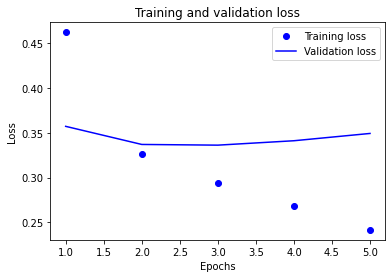

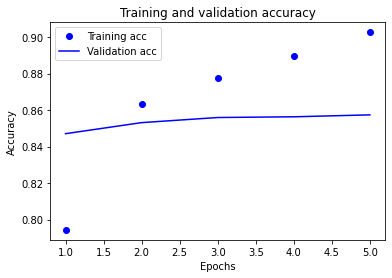

In [31]:
# LSTM의 손실, 정확도 그래프
import matplotlib.pyplot as plt

history_dict = history_lstm.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 그림을 초기화
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

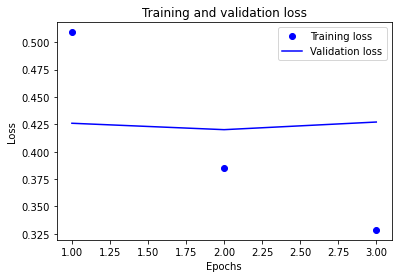

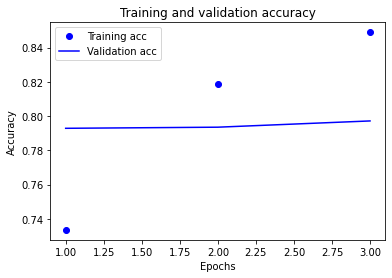

In [32]:
# 1-D CNN의 손실, 정확도 그래프
history_dict = history_cnn.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

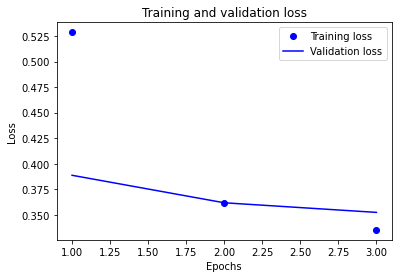

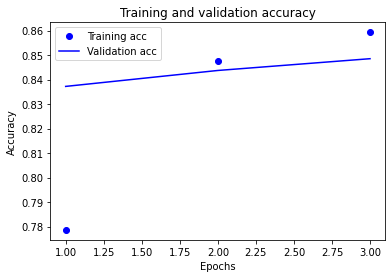

In [33]:
# one GlobalAveragePooling layer의 손실, 정확도 그래프
history_dict = history_simple.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Step 7. Embedding 레이어 분석

In [34]:
embedding_lstm = lstm.layers[0]
weights_lstm = embedding_lstm.get_weights()[0]
print(weights_lstm.shape)

embedding_cnn = cnn.layers[0]
weights_cnn = embedding_cnn.get_weights()[0]
print(weights_cnn.shape)

embedding_simple = simple.layers[0]
weights_simple = embedding_simple.get_weights()[0]
print(weights_simple.shape)

(10000, 200)
(10000, 200)
(10000, 200)


In [35]:
# 먼저 Word2VecKeyedVectors 라이브러리를 gensim.models.keyedvectors에서 불러들인다.
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 학습한 Embedding 파라미터를 파일에 써서 저장해야 한다.
# 먼저 LSTM 모델 저장
word2vec_file_path_lstm = '/content/drive/MyDrive/AIFFEL/word2vec_lstm.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))   # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 쓴다.

vectors = lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

# 다음으로 1-D CNN 모델
word2vec_file_path_cnn = '/content/drive/MyDrive/AIFFEL/word2vec_cnn.txt'
f = open(word2vec_file_path_cnn, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = cnn.get_weights()[0]
for i in range(4, vocab_size):
  f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

# 마지막으로 one GlobalAveragePooling layer 모델
word2vec_file_path_simple = '/content/drive/MyDrive/AIFFEL/word2vec_simple.txt'
f = open(word2vec_file_path_simple, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = simple.get_weights()[0]
for i in range(4, vocab_size):
  f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors_lstm = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)
word_vectors_cnn = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_cnn, binary=False)
word_vectors_simple = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_simple, binary=False)

In [36]:
# 모델별로 부정적인 단어 "환불"과 의미가 비슷한 단어 집계
word_vectors_lstm.similar_by_word("환불")

[('애니스톤', 0.8380591869354248),
 ('대놓고', 0.8349980115890503),
 ('돌려주', 0.8344278335571289),
 ('질색', 0.8293272256851196),
 ('철없', 0.827876091003418),
 ('배신감', 0.8271976113319397),
 ('퉤', 0.8253000378608704),
 ('신파', 0.8248072862625122),
 ('그지', 0.8228484988212585),
 ('어중간', 0.8228104114532471)]

In [37]:
word_vectors_cnn.similar_by_word("환불")

[('마이너스', 0.7805824279785156),
 ('잠들', 0.779607892036438),
 ('안드로메다', 0.7742705345153809),
 ('기대치', 0.7742506861686707),
 ('하품', 0.7736217975616455),
 ('엉성', 0.7709055542945862),
 ('잠든', 0.7708334922790527),
 ('써도', 0.770341157913208),
 ('헛웃음', 0.7682490348815918),
 ('졸음', 0.7649914622306824)]

In [38]:
word_vectors_simple.similar_by_word("환불")

[('볼일', 0.8854955434799194),
 ('아까운', 0.8843091130256653),
 ('허접', 0.8835663795471191),
 ('갑자기', 0.8817178010940552),
 ('낭비', 0.8815053105354309),
 ('반개', 0.8811264634132385),
 ('개연', 0.8811008930206299),
 ('끌', 0.8800340890884399),
 ('어색', 0.8799312114715576),
 ('아깝', 0.8787446022033691)]

In [39]:
# 모델별로 긍정적인 단어 "찡해"와 의미가 비슷한 단어 집계
word_vectors_lstm.similar_by_word("찡해")

[('넋', 0.8706719875335693),
 ('아름다워요', 0.8701093792915344),
 ('완소', 0.869227409362793),
 ('리얼리즘', 0.8671440482139587),
 ('그리움', 0.8657599687576294),
 ('지났', 0.8630126714706421),
 ('잼따', 0.8621929287910461),
 ('묻히', 0.861965537071228),
 ('졸이', 0.8616402745246887),
 ('에로티시즘', 0.8607469797134399)]

In [40]:
word_vectors_cnn.similar_by_word("찡해")

[('밋기', 0.7231262922286987),
 ('먹먹해', 0.7054176330566406),
 ('군더더기', 0.6906536817550659),
 ('요세', 0.6801871061325073),
 ('편도', 0.674139678478241),
 ('최상', 0.671164870262146),
 ('우왕', 0.6685270071029663),
 ('다행히', 0.6632820963859558),
 ('틈', 0.6622179746627808),
 ('올려야', 0.6561142206192017)]

In [41]:
word_vectors_simple.similar_by_word("찡해")

[('군더더기', 0.9495397806167603),
 ('먹먹', 0.9487399458885193),
 ('슬퍼요', 0.9475003480911255),
 ('미남', 0.9466584920883179),
 ('여운', 0.9465543031692505),
 ('슬펐', 0.9464037418365479),
 ('신들린', 0.94593346118927),
 ('탄탄', 0.9456948041915894),
 ('귀여워', 0.9455199241638184),
 ('가히', 0.9455002546310425)]

# Step 8. 한국어 Word2Vec 적용 및 성능 개선

In [101]:
import numpy as np
import pprint

path = '/content/drive/MyDrive/AIFFEL/word2vec_ko.model'
ko_vec = Word2VecKeyedVectors.load(path)

print(ko_vec.wv["배우"]) # ko_vec["배우"]방식은 deprecated라고 한다.
pprint.pprint(ko_vec.wv.most_similar("배우")) #마찬가지로 ko_vec.most_similar() 방식도 deprecated. 지양하자.

ko_vec = ko_vec.wv # ko_vec.wv대신 ko_vec을 사용하면 아래에서도 deprecated 경고 발생

[-0.58881295 -4.3877287  -3.4858546  -2.3084912   0.87703085  6.4445586
 -1.1062126  -2.2230182  -0.78621733  1.9408462  -1.1357461   1.0119969
 -0.30329964 -5.455517    2.6356647  -5.2909884  -1.744448    2.5409734
  3.716852   -1.4752581  -1.1985137   3.5504315  -0.41522408 -0.2436183
  1.5218438  -3.4603841   1.1120543   0.39729053 -2.707328    1.3680482
 -4.2843776   3.014664    2.6393197   0.9804478  -1.0825127   3.6201363
  3.1546066   0.9634868   1.3677765   0.82937515  1.9380125  -2.6699877
 -0.41389105  2.7402463   3.415545   -0.37949705  4.4021254   1.2531414
  2.504994    0.33631453 -2.0658643  -3.1885884   6.659477   -5.47897
  3.1113489   1.6667893   2.8441331  -1.1597652  -0.19843072 -0.07214008
  0.47545317  4.105001   -0.20690314 -4.399607   -0.32254001  2.030352
  0.35149667 -4.0907154   1.12323    -1.873176    2.422429    1.9751279
 -0.9144355   4.34507    -1.0122209   3.4604955  -2.2505796  -5.2072535
  1.4032923   0.7049264   2.6884458   0.11147156  1.4308741   0.03

In [104]:
vocab_size_ko_vec = 10000
word_vector_dim_ko_vec = 100

embedding_matrix = np.random.rand(vocab_size_ko_vec, word_vector_dim_ko_vec)

for i in range(4,vocab_size_ko_vec):
    if index_to_word[i] in ko_vec:
        embedding_matrix[i] = ko_vec[index_to_word[i]]

## 모델에 Word2Vec 적용

In [105]:
from tensorflow.keras.initializers import Constant

In [106]:
vocab_size = 10000
word_vector_dim = 100

# LSTM
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
lstm.add(keras.layers.LSTM(128))
lstm.add(keras.layers.Dense(128, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

lstm.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 44, 100)           1000000   
                                                                 
 lstm_5 (LSTM)               (None, 128)               117248    
                                                                 
 dense_18 (Dense)            (None, 128)               16512     
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,133,889
Trainable params: 1,133,889
Non-trainable params: 0
_________________________________________________________________


In [107]:
# 1-D CNN
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
cnn.add(keras.layers.Dropout(0.5))
cnn.add(keras.layers.Conv1D(512, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(512, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(256, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 44, 100)           1000000   
                                                                 
 dropout_2 (Dropout)         (None, 44, 100)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 38, 512)           358912    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 7, 512)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 512)            1835520   
                                                                 
 global_max_pooling1d_2 (Glo  (None, 512)              0         
 balMaxPooling1D)                                    

In [108]:
# one GlobalAveragePooling1D layer
simple = keras.Sequential()
simple.add(keras.layers.Embedding(vocab_size, 
                                  word_vector_dim, 
                                  embeddings_initializer=Constant(embedding_matrix),
                                  input_length=maxlen, 
                                  trainable=True))

simple.add(keras.layers.GlobalAveragePooling1D())
simple.add(keras.layers.Dense(128, activation='relu'))
simple.add(keras.layers.Dropout(0.1))
simple.add(keras.layers.Dense(1, activation='sigmoid'))

simple.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 44, 100)           1000000   
                                                                 
 global_average_pooling1d_2   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_22 (Dense)            (None, 128)               12928     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,013,057
Trainable params: 1,013,057
Non-trainable params: 0
___________________________________________

In [109]:
# 한국어 Word2Vec 적용된 LSTM 모델 훈련
epochs = 4

lstm.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history_lstm = lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/4
247/247 [==============================] - 6s 15ms/step - loss: 0.4691 - accuracy: 0.7734 - val_loss: 0.3790 - val_accuracy: 0.8303
Epoch 2/4
247/247 [==============================] - 3s 12ms/step - loss: 0.3481 - accuracy: 0.8467 - val_loss: 0.3397 - val_accuracy: 0.8508
Epoch 3/4
247/247 [==============================] - 3s 13ms/step - loss: 0.3009 - accuracy: 0.8706 - val_loss: 0.3232 - val_accuracy: 0.8603
Epoch 4/4
247/247 [==============================] - 3s 13ms/step - loss: 0.2686 - accuracy: 0.8873 - val_loss: 0.3183 - val_accuracy: 0.8655


In [110]:
# 한국어 Word2Vec 적용된 1-D CNN 모델 훈련
epochs = 10

cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_cnn = cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 8s 31ms/step - loss: 0.7328 - accuracy: 0.6090 - val_loss: 0.5789 - val_accuracy: 0.6946
Epoch 2/10
247/247 [==============================] - 7s 27ms/step - loss: 0.5647 - accuracy: 0.7005 - val_loss: 0.5302 - val_accuracy: 0.7301
Epoch 3/10
247/247 [==============================] - 7s 28ms/step - loss: 0.5221 - accuracy: 0.7326 - val_loss: 0.4947 - val_accuracy: 0.7559
Epoch 4/10
247/247 [==============================] - 7s 28ms/step - loss: 0.4932 - accuracy: 0.7503 - val_loss: 0.4862 - val_accuracy: 0.7567
Epoch 5/10
247/247 [==============================] - 7s 28ms/step - loss: 0.4714 - accuracy: 0.7642 - val_loss: 0.4492 - val_accuracy: 0.7776
Epoch 6/10
247/247 [==============================] - 7s 27ms/step - loss: 0.4539 - accuracy: 0.7741 - val_loss: 0.4524 - val_accuracy: 0.7786
Epoch 7/10
247/247 [==============================] - 7s 28ms/step - loss: 0.4397 - accuracy: 0.7836 - val_loss: 0.4447 - val_accuracy: 0.7814

In [111]:
# 한국어 Word2Vec 적용된 one GlobalAveragePooling1D layer 모델 훈련
epochs = 6

simple.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_simple = simple.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/6
247/247 [==============================] - 2s 5ms/step - loss: 0.5772 - accuracy: 0.6929 - val_loss: 0.4919 - val_accuracy: 0.7721
Epoch 2/6
247/247 [==============================] - 1s 5ms/step - loss: 0.4538 - accuracy: 0.7920 - val_loss: 0.4184 - val_accuracy: 0.8110
Epoch 3/6
247/247 [==============================] - 1s 5ms/step - loss: 0.3991 - accuracy: 0.8233 - val_loss: 0.3869 - val_accuracy: 0.8276
Epoch 4/6
247/247 [==============================] - 1s 5ms/step - loss: 0.3697 - accuracy: 0.8377 - val_loss: 0.3665 - val_accuracy: 0.8415
Epoch 5/6
247/247 [==============================] - 1s 5ms/step - loss: 0.3524 - accuracy: 0.8466 - val_loss: 0.3569 - val_accuracy: 0.8447
Epoch 6/6
247/247 [==============================] - 1s 5ms/step - loss: 0.3398 - accuracy: 0.8532 - val_loss: 0.3532 - val_accuracy: 0.8446


In [112]:
# 각 모델 평가

# LSTM
results_lstm = lstm.evaluate(X_test, y_test, verbose=2)
print(results_lstm)

# 1-D CNN
results_cnn = cnn.evaluate(X_test, y_test, verbose=2)
print(results_cnn)

# one GlobalAveragePooling1D layer
results_simple = simple.evaluate(X_test, y_test, verbose=2)
print(results_simple)

1537/1537 - 4s - loss: 0.3265 - accuracy: 0.8620 - 4s/epoch - 3ms/step
[0.32651486992836, 0.8619728684425354]
1537/1537 - 4s - loss: 0.4375 - accuracy: 0.7887 - 4s/epoch - 3ms/step
[0.4374760687351227, 0.7886770963668823]
1537/1537 - 2s - loss: 0.3650 - accuracy: 0.8419 - 2s/epoch - 2ms/step
[0.36497989296913147, 0.8418943285942078]


# 회고

이번 노드는 konlpy, Mecab, gensim과 같이 NLP에서 중요한 기능을 하는 라이브러리 및 모듈을 받는 과정부터 어려움을 겪기 시작한 노드였던 거 같다. 버전이 안 맞는다거나 아니면 설치 명령어 자체가 어렵다거나 등등의 이유로 말이다. 하지만 설치를 제대로 하고 버전까지 확인을 제대로 하게 되면 그래도 실행이 정상적으로 이루어졌음을 확인했다.

이번 영화 리뷰 감성 분석은 댓글을 단 사람들의 리뷰가 긍정적인 리뷰인지 부정적인 리뷰인지를 확인하는 모델을 생성하는 과정을 배웠다고 요약할 수 있을 거 같다. 그런 다음 실제로 긍정적 혹은 부정적인 의미를 담는 의미와 유사성이 있는 단어들을 얼마나 잘 찾아내는지, 그리고 그 정확도가 어떠한지를 평가하는 것으로 마무리된다.  
저 같은 경우는 세 가지 모델(LSTM, 1-D CNN, one GlobalAveragePooling layer)을 각각 구현해 냈으며, 정확도는 이 세 가지 모델 중 LSTM 모델이 가장 높은 85 ~ 86%를 보여 가장 성능이 우수한 모델이라는 것까지 밝혀냈다. 코드 구성 및 내용적인 면에서 상당히 많은 이해력을 요구하는 노드였지만 결과는 나름 좋게 나온 거 같아 만족스러웠다.